
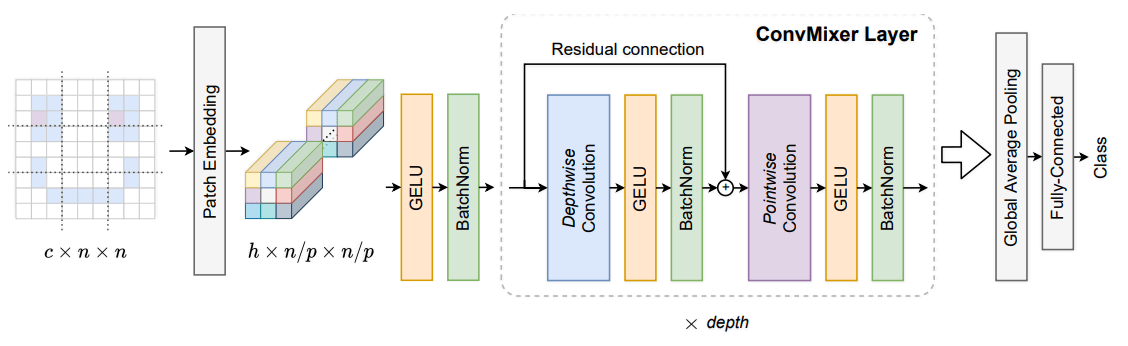

<i> ConvMixer Layer from the paper [1]</i>


## References
1. Trockman, A., & Kolter, J. Z. (2022). Patches Are All You Need? (Version 1). arXiv. https://doi.org/10.48550/ARXIV.2201.09792
2. https://keras.io/examples/vision/convmixer


## Credit

https://www.kaggle.com/code/banddaniel


In [1]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer



In [19]:
IMG_SIZE = 128,128 #40,40 initially, but lets try something larger
BATCH_SIZE = 32
SEED = 5
AUTO = tf.data.AUTOTUNE

In [4]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in images:
        full_path.append(os.path.join(path, i))
        
    return full_path


moon = create_images_list('/kaggle/input/jellyfish-types/Moon_jellyfish')
barrel = create_images_list('/kaggle/input/jellyfish-types/barrel_jellyfish')
blue = create_images_list('/kaggle/input/jellyfish-types/blue_jellyfish')
compass = create_images_list('/kaggle/input/jellyfish-types/compass_jellyfish')
lions_mane = create_images_list('/kaggle/input/jellyfish-types/lions_mane_jellyfish')
mauve_stinger = create_images_list('/kaggle/input/jellyfish-types/mauve_stinger_jellyfish')

# look-up table
jellyfish_classes = {0:'Moon', 1 : 'Barrel', 2 : 'Blue', 3 : 'Compass', 4 : 'Lion’s mane', 5: 'Mauve stinger'}


data_df = pd.concat([pd.DataFrame({"img" : np.array(moon) , "label": 0 }),
                     pd.DataFrame({"img" : np.array(barrel) , "label": 1 }),
                     pd.DataFrame({"img" : np.array(blue) , "label": 2 }),
                     pd.DataFrame({"img" : np.array(compass) , "label": 3 }),
                     pd.DataFrame({"img" : np.array(lions_mane) , "label": 4 }),
                     pd.DataFrame({"img" : np.array(mauve_stinger) , "label": 5 }) ], ignore_index = True)

data_df = shuffle(data_df, random_state = SEED).reset_index(drop = True)
data_df.head()

,img,label
0,/kaggle/input/jellyfish-types/compass_jellyfis...,3
1,/kaggle/input/jellyfish-types/lions_mane_jelly...,4
2,/kaggle/input/jellyfish-types/mauve_stinger_je...,5
3,/kaggle/input/jellyfish-types/mauve_stinger_je...,5
4,/kaggle/input/jellyfish-types/Moon_jellyfish/a...,0


In [12]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def display_image_grid(folder_path):
    # Get a list of files in the specified folder
    file_list = os.listdir(folder_path)

    # Ensure that there are at least 16 files in the folder
    if len(file_list) < 16:
        print("Error: There should be at least 16 images in the folder.")
        return

    # Create a 4x4 grid of subplots
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))

    # Iterate through the first 16 files in the folder
    for i, file_name in enumerate(file_list[:16]):
        # Load the image from the file
        image_path = os.path.join(folder_path, file_name)
        image = Image.open(image_path)
        image_array = np.array(image)

        # Display the image on the current subplot
        row = i // 4
        col = i % 4
        axes[row, col].imshow(image_array)
        axes[row, col].axis('off')

        # Print the size of the image
        image_size = image.size
        print(f"Image {i + 1}: {file_name}, Size: {image_size}")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()



Image 1: aug-88-54.jpg, Size: (224, 224)
Image 2: aug-63-24.jpg, Size: (179, 179)
Image 3: 45.jpg, Size: (224, 224)
Image 4: 56.jpg, Size: (224, 224)
Image 5: 58.jpg, Size: (224, 224)
Image 6: aug-97-04.jpg, Size: (179, 179)
Image 7: aug-2-03.jpg, Size: (224, 224)
Image 8: aug-68-30.jpg, Size: (224, 224)
Image 9: aug-96-03.jpg, Size: (179, 179)
Image 10: aug-35-47.jpg, Size: (224, 224)
Image 11: aug-22-31.jpg, Size: (179, 179)
Image 12: aug-21-30.jpg, Size: (224, 224)
Image 13: aug-42-55.jpg, Size: (179, 179)
Image 14: aug-60-18.jpg, Size: (224, 224)
Image 15: aug-58-16.jpg, Size: (179, 179)
Image 16: 30.jpg, Size: (224, 224)


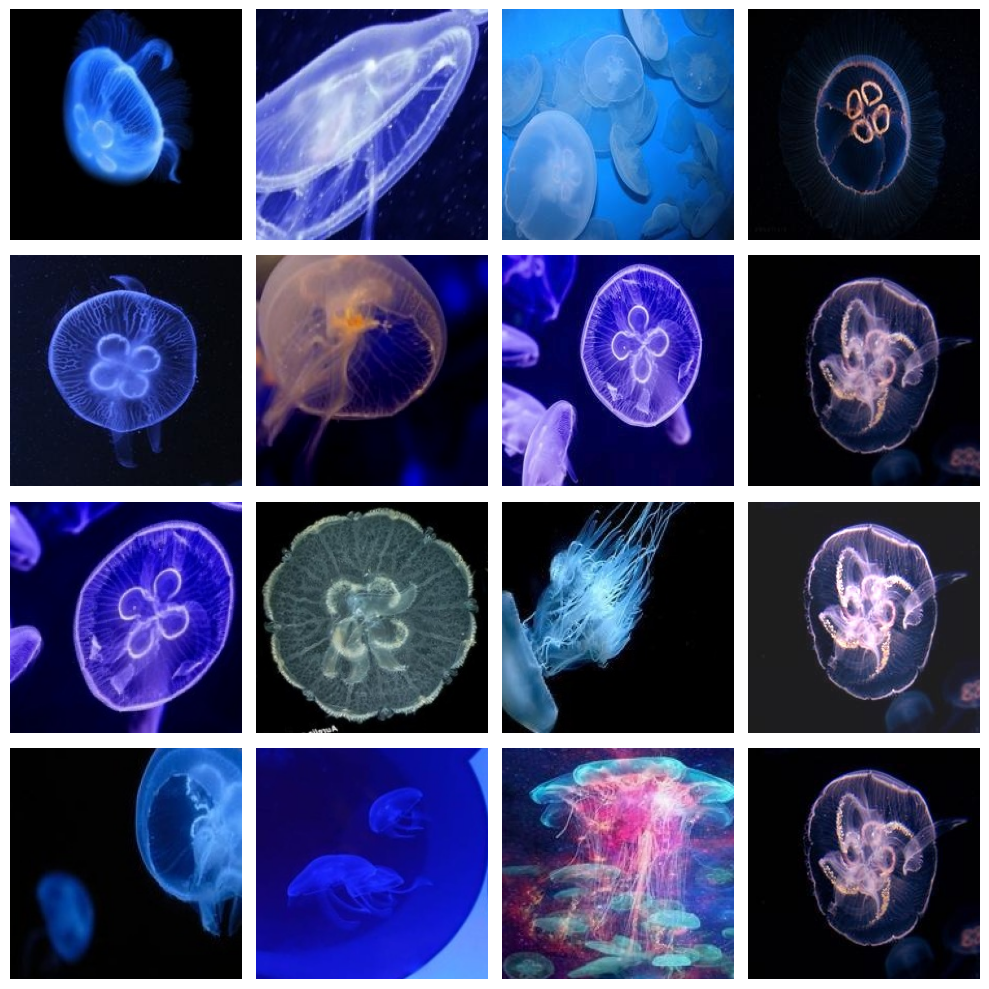

In [13]:
display_image_grid('/kaggle/input/jellyfish-types/Moon_jellyfish')

In [16]:
import os
from PIL import Image
import pandas as pd

def get_image_sizes(folder_path):
    # Get a list of files in the specified folder
    file_list = os.listdir(folder_path)

    # Create an empty DataFrame to store the results
    data = {'File Name': [], 'Image Size': []}
    df = pd.DataFrame(data)

    # Iterate through the files in the folder
    for file_name in file_list:
        # Load the image from the file
        image_path = os.path.join(folder_path, file_name)
        image = Image.open(image_path)

        # Get the size of the image
        image_size = image.size

        # Add the information to the DataFrame
        df = pd.concat([df, pd.DataFrame({'File Name': [file_name], 'Image Size': [image_size]})], ignore_index=True)

    return df

def get_all_image_sizes(root_folder, excluded_folders=[]):
    # Create an empty DataFrame to store the results
    all_image_sizes_df = pd.DataFrame()

    # Iterate through subfolders
    for subfolder in os.listdir(root_folder):
        subfolder_path = os.path.join(root_folder, subfolder)

        # Check if it's a directory and not in the list of excluded folders
        if os.path.isdir(subfolder_path) and subfolder not in excluded_folders:
            # Get image sizes for the current subfolder
            subfolder_df = get_image_sizes(subfolder_path)

            # Add the results to the main DataFrame
            all_image_sizes_df = pd.concat([all_image_sizes_df, subfolder_df], ignore_index=True)

    return all_image_sizes_df


# path to the root folder containing subfolders with images
root_folder = '/kaggle/input/jellyfish-types'

# Specify folders to exclude
excluded_folders = ['Train_Test_Valid']

# Get all image sizes excluding specified folders
result_df = get_all_image_sizes(root_folder, excluded_folders)

# Display the resulting DataFrame
print(result_df)


          File Name  Image Size
0     aug-88-54.jpg  (224, 224)
1     aug-63-24.jpg  (179, 179)
2            45.jpg  (224, 224)
3            56.jpg  (224, 224)
4            58.jpg  (224, 224)
..              ...         ...
895   aug-45-59.jpg  (179, 179)
896  aug-55-71.jpeg  (179, 179)
897   aug-57-01.JPG  (179, 179)
898          25.jpg  (224, 224)
899   aug-68-14.jpg  (179, 179)

[900 rows x 2 columns]


check the different sizes of the images, to see if there are any imgaes that are extremely larger of smaller then the others

In [18]:
result_df['Image Size'].unique()

array([(224, 224), (179, 179)], dtype=object)

# <span style="color:#e74c3c;"> Creating </span> Train, Val, Test Datasets

In [20]:
# splitting into train_df (train and valid) and test_df
test_idx = data_df.shape[0] * 15 // 100  # 15 % for testing 

train_df = data_df[test_idx:].reset_index(drop = True)
test_df = data_df[:test_idx].reset_index(drop = True)


print("train_df (train and val) shape -> ", train_df.shape[0])
print("test_df shape -> ", test_df.shape[0])

train_df (train and val) shape ->  765
test_df shape ->  135


# <span style="color:#e74c3c;"> Creating </span> Custom ConvMixer Layer

In [21]:
class ConvMixerBlock(Layer):
    def __init__(self, filters, kernel_size, patch_size, **kwargs):
        super(ConvMixerBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        
        self.deepwise = DepthwiseConv2D(kernel_size = kernel_size, padding = 'same')
        self.conv1 = Conv2D(filters, kernel_size = 1)
        self.act = Activation('gelu')
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        X = self.deepwise(inputs)
        X = self.act(X)
        X = self.bn1(X)
        X = Add()([X, inputs])
        X = self.conv1(X)
        X = self.act(X)
        X = self.bn2(X)
            
        return X
      
    
    def get_config(self):
        base_config = super().get_config()
        
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "patch_size": self.patch_size}

# <span style="color:#e74c3c;"> Model </span>


In [22]:
FEATURES = 256
inp = Input(shape = (*IMG_SIZE, 3))

X = Conv2D(FEATURES, 2, 2)(inp)
X = Activation('gelu')(X)
X = BatchNormalization()(X)

X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_1')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_2')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_3')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_4')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_5')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_6')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_7')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_8')(X)


X = GlobalAveragePooling2D()(X)
out = Dense(6, activation = 'softmax')(X)

model = Model(inputs = inp, outputs = out)
model.summary()
    
model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001,weight_decay = 0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['acc',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None) ] )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 256)       3328      
                                                                 
 activation (Activation)     (None, 64, 64, 256)       0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 256)      1024      
 ormalization)                                                   
                                                                 
 CONVMIXER_1 (ConvMixerBlock  (None, 64, 64, 256)      74496     
 )                                                               
                                                                 
 CONVMIXER_2 (ConvMixerBlock  (None, 64, 64, 256)      74496 

# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [23]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label


# Basic data augmentation 
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image)
    img = tf.image.random_flip_up_down(img)
    
    return image, label

In [24]:
# Creating test dataset loader and tf.dataset

test_loader = tf.data.Dataset.from_tensor_slices((test_df['img'], test_df['label']))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

# <span style="color:#e74c3c;"> 10 Folds Training</span> 

In [25]:
fold_hists = []
test_evals = []
test_preds = []

EPOCHS = 20
FOLDS = 10

kf = KFold(n_splits = FOLDS, shuffle = True, random_state = SEED)

for i, (train_index, val_index) in  enumerate(kf.split(train_df['img'], train_df['label'])):
    
    print('-'*90)
    print(str(i+1) + '.fold training')
    
    X_train_fold = train_df['img'][train_index]
    y_train_fold = train_df['label'][train_index]
    
    X_val_fold = train_df['img'][val_index]
    y_val_fold = train_df['label'][val_index]


    # Creating tf.pipeline
    train_loader = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
    train_dataset = (train_loader
                     .map(img_preprocessing, num_parallel_calls = AUTO)
                     .map(augmentation, num_parallel_calls = AUTO)
                     .batch(BATCH_SIZE)
                     .shuffle(BATCH_SIZE*5)
                     .prefetch(AUTO))
    
    validation_loader = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))
    validation_dataset = (validation_loader
                          .map(img_preprocessing, num_parallel_calls = AUTO)
                          .batch(BATCH_SIZE)
                          .prefetch(AUTO))
    
    
    # Training
    hist = model.fit(train_dataset, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data = validation_dataset, verbose = 0)
    fold_hists.append(hist)
    
    # Test evaluation
    test_eval = model.evaluate(test_dataset)
    test_evals.append(test_eval)
    print('Test Loss: {0:.3f}'.format(test_eval[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval[1]*100))
    print('Test Sparse Top 2 Accuracy: {0:.2f} %'.format(test_eval[2]*100))
    
    # Test set prediction
    test_take1 =  test_dataset.take(-1)
    test_take1_ = list(test_take1)
    pred = model.predict(test_take1)
    test_preds.append(pred)

------------------------------------------------------------------------------------------
1.fold training
5/5 [==============================] - 1s 149ms/step - loss: 3.2075 - acc: 0.1185 - top_3_acc: 0.5185
Test Loss: 3.208
Test Accuracy: 11.852 %
Test Sparse Top 2 Accuracy: 51.85 %
5/5 [==============================] - 1s 168ms/step
------------------------------------------------------------------------------------------
2.fold training
5/5 [==============================] - 1s 140ms/step - loss: 0.9401 - acc: 0.7407 - top_3_acc: 0.9407
Test Loss: 0.940
Test Accuracy: 74.074 %
Test Sparse Top 2 Accuracy: 94.07 %
5/5 [==============================] - 1s 169ms/step
------------------------------------------------------------------------------------------
3.fold training
5/5 [==============================] - 1s 140ms/step - loss: 0.5543 - acc: 0.8370 - top_3_acc: 0.9778
Test Loss: 0.554
Test Accuracy: 83.704 %
Test Sparse Top 2 Accuracy: 97.78 %
5/5 [==============================]

# <span style="color:#e74c3c;"> Training </span> Results

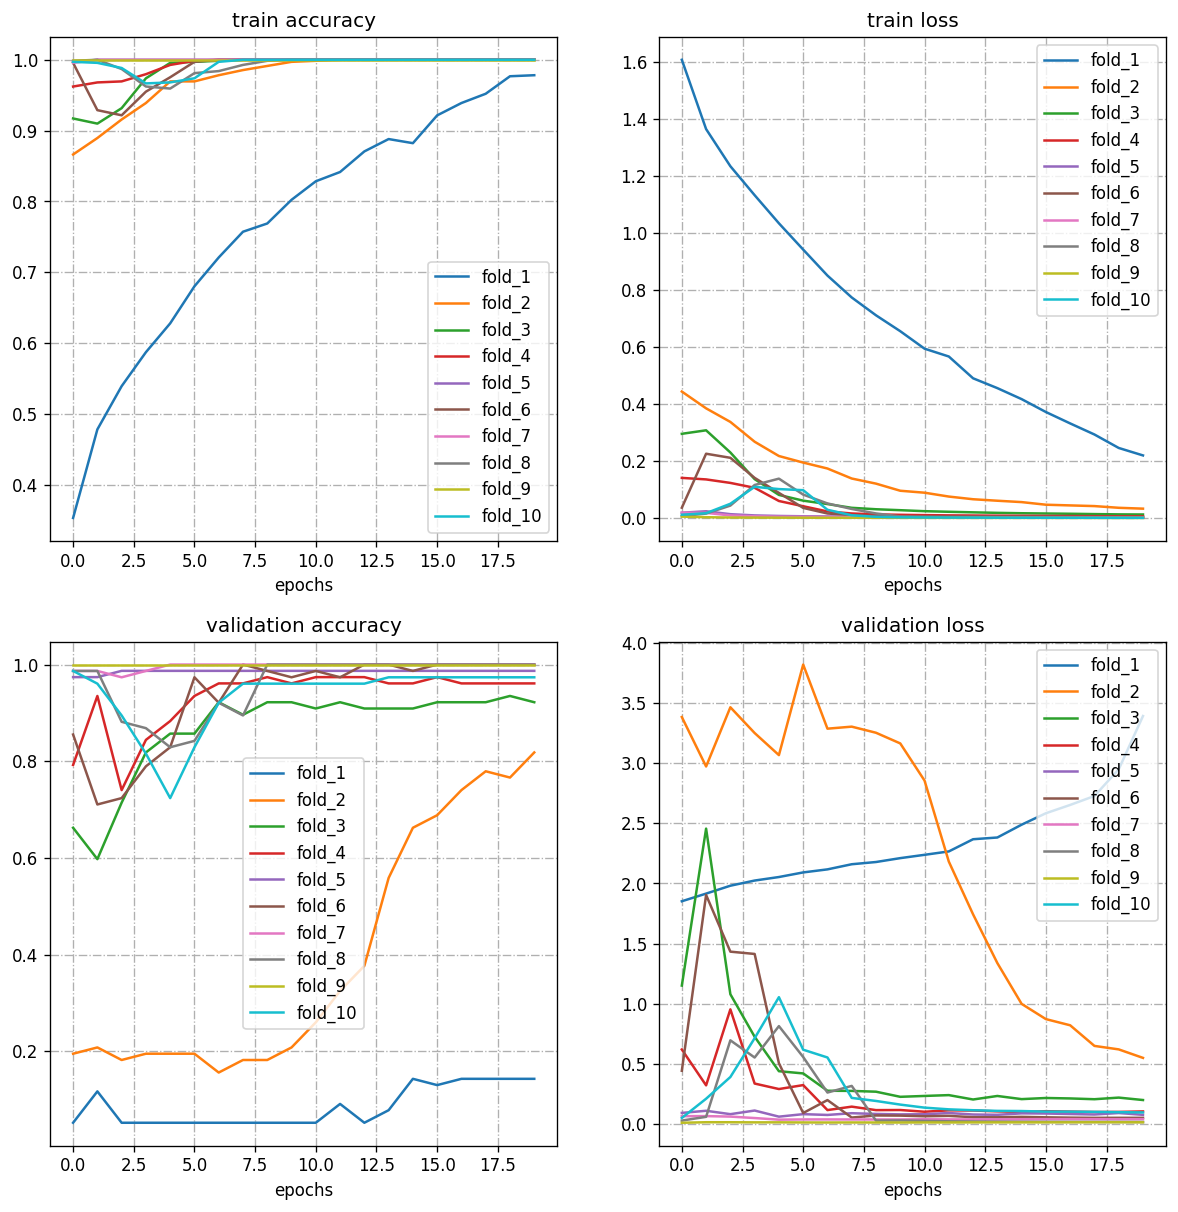

In [26]:
fig, axs = plt.subplots(2,2, figsize = (12,12) ,dpi = 120)

folds_name = []

axs[0][0].set_title('train accuracy')
axs[0][0].grid(linestyle = 'dashdot')
axs[0][0].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[0][0].plot(fold_hists[i].history['acc'])
    folds_name.append('fold_' + str(i + 1) )
axs[0][0].legend(folds_name, fontsize = 10)


axs[0][1].set_title('train loss')
axs[0][1].grid(linestyle = 'dashdot')
axs[0][1].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[0][1].plot(fold_hists[i].history['loss'])
axs[0][1].legend(folds_name, fontsize = 10)


axs[1][0].set_title('validation accuracy')
axs[1][0].grid(linestyle = 'dashdot')
axs[1][0].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[1][0].plot(fold_hists[i].history['val_acc'])
axs[1][0].legend(folds_name, fontsize = 10)


axs[1][1].set_title('validation loss')
axs[1][1].grid(linestyle = 'dashdot')
axs[1][1].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[1][1].plot(fold_hists[i].history['val_loss'])
axs[1][1].legend(folds_name, fontsize = 10)


# <span style="color:#e74c3c;"> Ensemble Test </span> Predictions

In [27]:
# Calculating the mean of 10 folds predictions

preds = np.mean(test_preds, axis = 0)
last_pred = np.argmax(preds, axis = 1)

# <span style="color:#e74c3c;"> Test Classification </span> Report

In [28]:
clf = classification_report(test_df['label'] , last_pred, target_names = list(jellyfish_classes.values()))
print(clf)

               precision    recall  f1-score   support

         Moon       0.84      1.00      0.91        16
       Barrel       0.90      1.00      0.95        19
         Blue       0.93      0.79      0.85        33
      Compass       0.94      0.76      0.84        21
  Lion’s mane       0.75      0.94      0.83        16
Mauve stinger       0.97      0.97      0.97        30

     accuracy                           0.90       135
    macro avg       0.89      0.91      0.89       135
 weighted avg       0.90      0.90      0.90       135



# <span style="color:#e74c3c;"> Test Confusion </span> Matrix

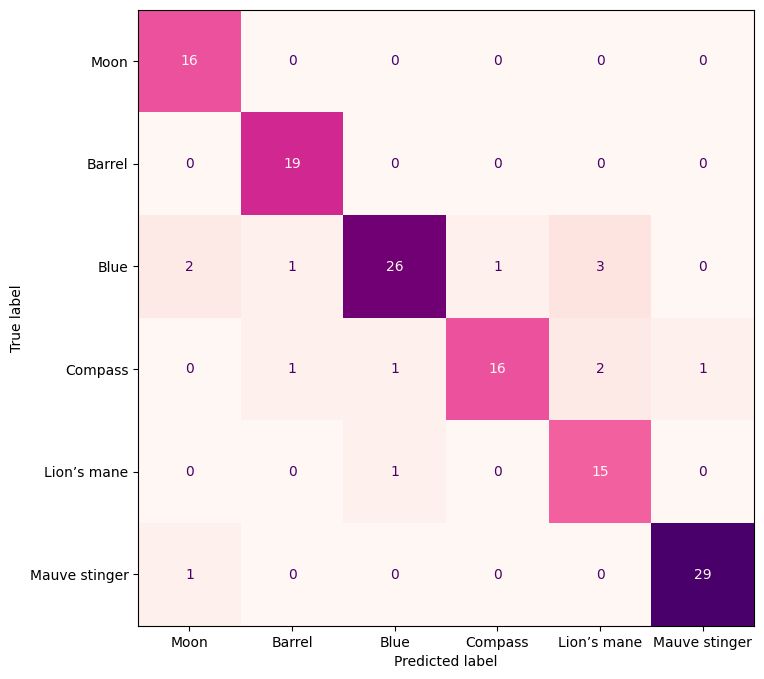

In [29]:
cm = confusion_matrix(test_df['label'] , last_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(jellyfish_classes.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cmd.plot(ax=ax,  cmap = 'RdPu', colorbar = False)

# <span style="color:#e74c3c;"> Test </span> Predictions

In [40]:
# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
    
def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(last_pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        

        if int(last_pred[idx[i]]) == label:
            axs[i].imshow(img) 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + 'true label: ' + jellyfish_classes[label] + '\n' + 'predicted label: ' + jellyfish_classes[int(last_pred[idx[i]])], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + 'true label: ' + jellyfish_classes[label] + '\n' + 'predicted label: ' + jellyfish_classes[int(last_pred[idx[i]])], fontsize = 8, color = 'red')

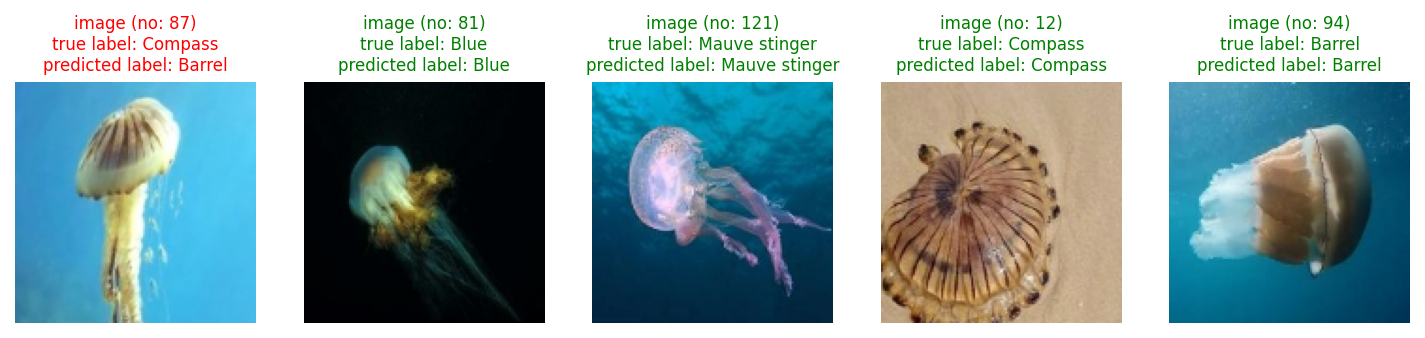

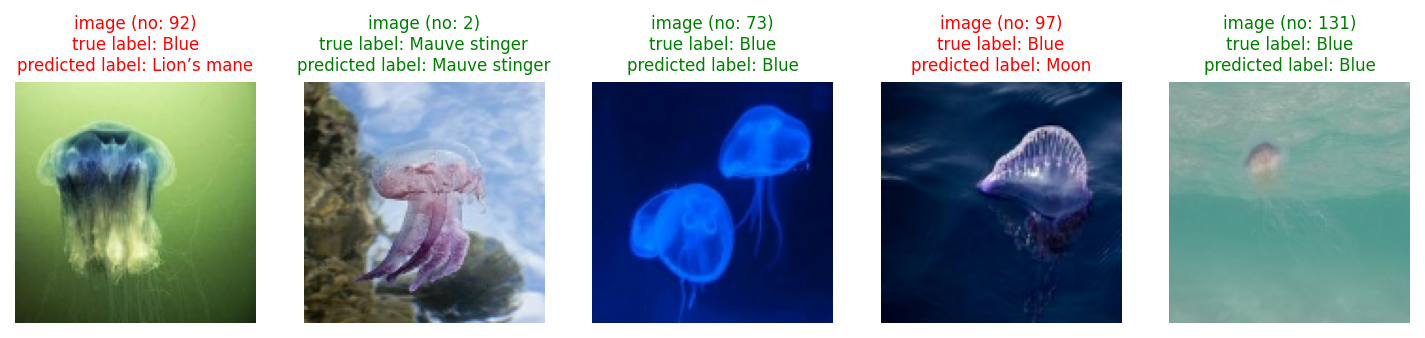

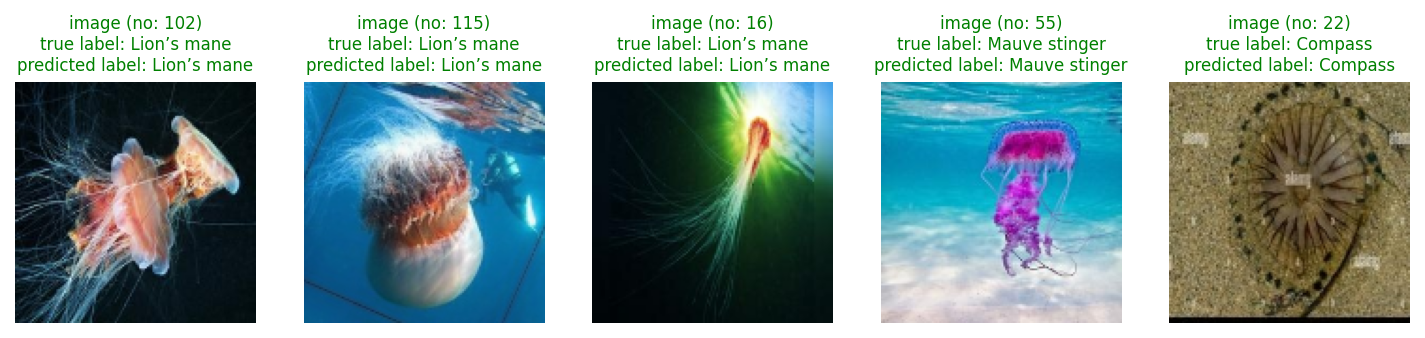

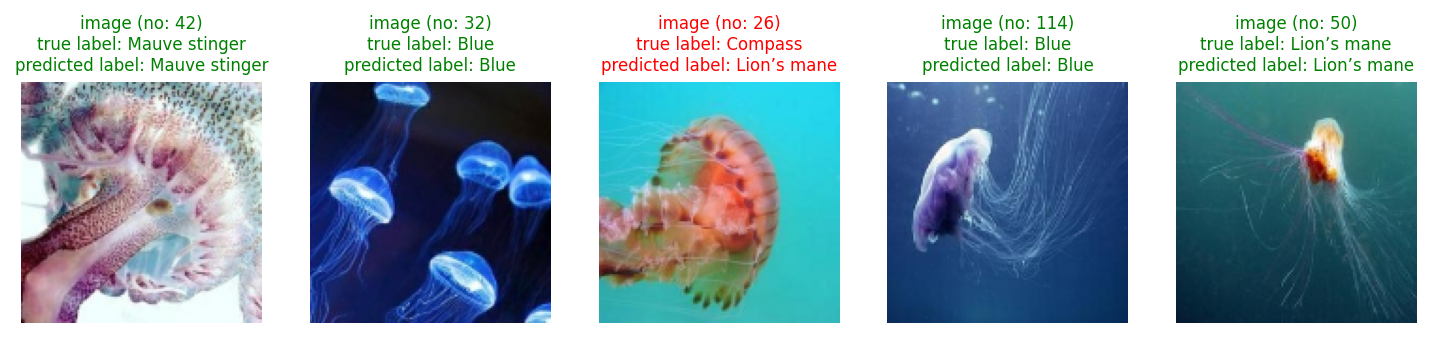

In [41]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 145)
random_test_sample_with_prediction(SEED = 7)
random_test_sample_with_prediction(SEED = 78)
random_test_sample_with_prediction(SEED = 98)